In [4]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import json

json_file_path = 'config.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data into a Python dictionary
    config = json.load(json_file)

score_dir = config["private_precomputed_score_dir"]
dataset_results = {}


for dataset in ["cifar10", "cifar100"]:
    scores_files_for_dataset = []
    for dir_name in os.listdir(score_dir):
        if dataset + "_" in dir_name:
            scores_files_for_dataset.append(dir_name)

    privacy_eps = np.concatenate([np.array([1.0]), np.arange(5.0, 105.0, 5.0)])
    avg_scores_for_eps = {}
    for eps in privacy_eps:
        for dir_name in scores_files_for_dataset:
            if f"_{eps}_" in dir_name:
                # 20 refers to the 20 epochs the DP models were trained for
                file_name = os.path.join(score_dir, dir_name, f"curv_scores_20_{dir_name}_0.001.pt")
                scores = torch.load(file_name)
                if eps in avg_scores_for_eps:
                    avg_scores_for_eps[eps] += scores
                else:
                    avg_scores_for_eps[eps] = scores
    score_avg = []
    for eps in privacy_eps:
        score_avg.append(avg_scores_for_eps[eps].mean().item() / len(privacy_eps))
        
    dataset_results[dataset] = (privacy_eps, score_avg)

[ 0.03925029 -0.01441703  0.04961067  0.01243414  0.00020469]
[-9.09210835e-01  1.12107606e+00  9.82449359e-02 -6.90278143e-05
  5.46112099e-04]


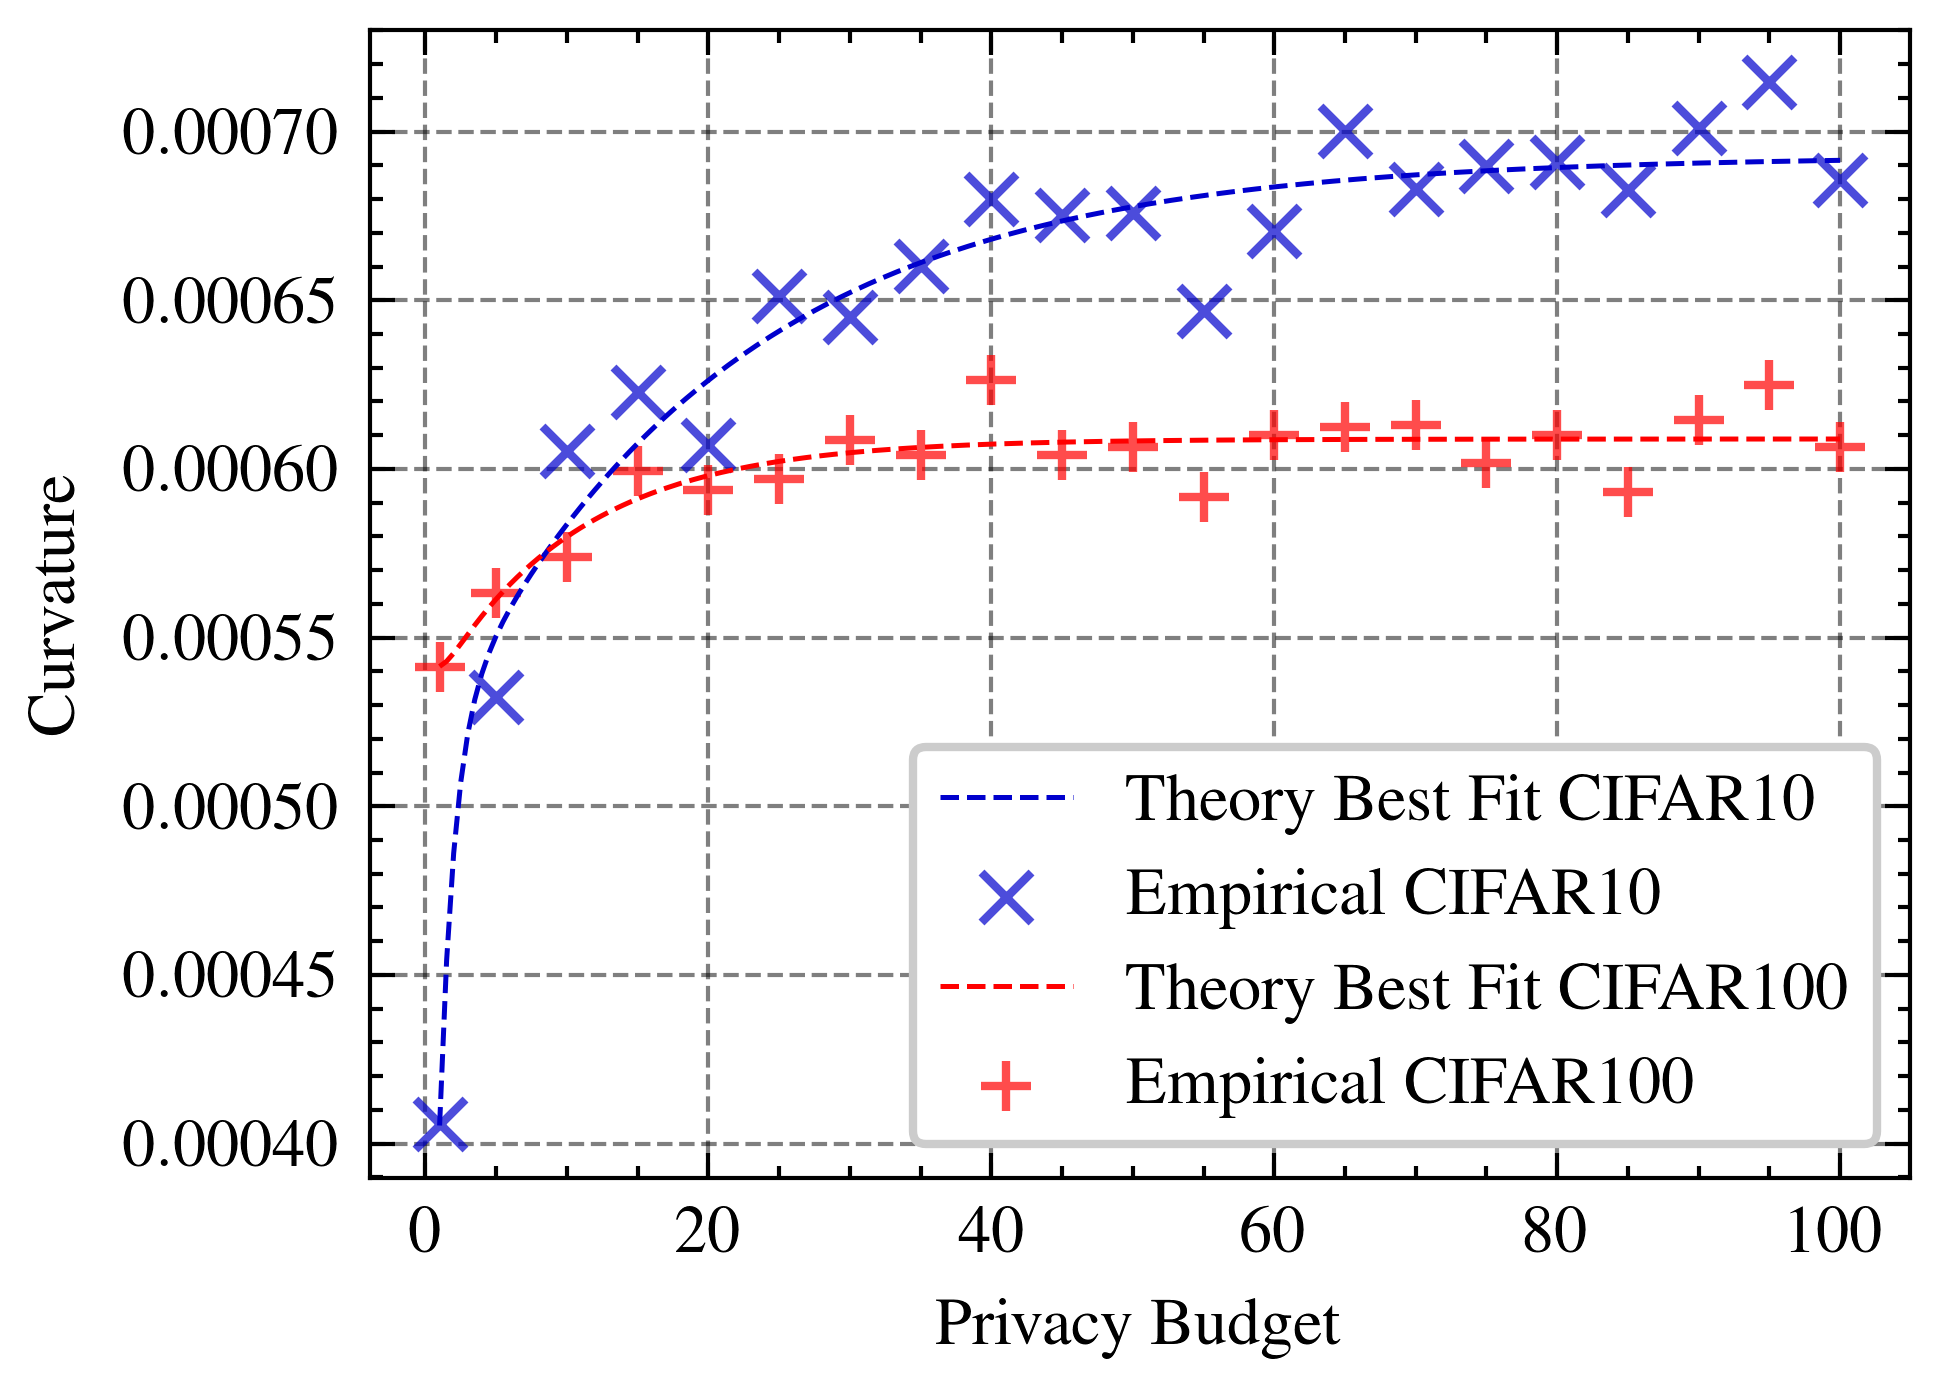

In [23]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scienceplots
plt.style.use(['ieee', 'science', 'grid'])


def curv_func(x, a, b, c, d, e):
    return (a + b * np.exp(-c * x)) * d * (1 - np.exp(-x)) + e

init = [[1.22966216, 0.45078766,  0.01254502,  0.00836795, 0], [1.22966216, 0.45078766,  0.01254502,  0.00836795, 0]]
markers = ['x', '+']

textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
colors=['mediumblue', 'red']

for dataset_idx, (dataset, result) in enumerate(dataset_results.items()):
    lin_model = LinearRegression()
    tr_x = np.array(result[0])
    tr_y = np.array(result[1])
    popt, pcov = curve_fit(curv_func, tr_x, tr_y, p0=init[dataset_idx])
    plotx = np.linspace(1, 100, 200)
    plt.plot(plotx, curv_func(plotx, *popt), linestyle='dashed', label=f'Theory Best Fit {dataset.upper()}', lw=0.6, c=colors[dataset_idx])
    plt.scatter(tr_x, tr_y, label=f'Empirical {dataset.upper()}', marker=markers[dataset_idx], c=colors[dataset_idx], alpha=0.7)

# Add legend with all entries
plt.legend(loc='lower right')
plt.xlabel("Privacy Budget")
plt.ylabel("Curvature")
plt.savefig("./plots/eps_v_curvature.png", dpi=300)
